# Step 2: Controlled Generation of Small Molecules with `MolMIM`

### RORc Nuclear Receptor Agonist Case-Study
Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

This tutorial demonstrates how to generate small molecules with [MolMIM](https://arxiv.org/abs/2208.09016). The `MolMIM` model generates small molecules while optimizing properties of interest with the [Covariance matrix adaptation evolution strategy (CMA-ES)](https://en.wikipedia.org/wiki/CMA-ES) algorithm. The basic steps in one iteration of the optimization are:

1. Decode latent representations into SMILES strings.
2. Score generated SMILES strings based on the oracle function.
3. Update the CMA-ES algorithm with the SMILES/score pairing.
4. Ask the CMA-ES algorithm for a new set of latent space representations to sample.

An API call to the [NVIDIA MolMIM NIM](https://docs.nvidia.com/nim/bionemo/molmim/latest/overview.html) will handle all of the above steps.

## 2.1 Set Up the Environment

In [1]:
!pip install rdkit python-dotenv pandas numpy matplotlib loguru py3dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.7 MB/s eta 0:00:00


In [2]:
import pickle
from typing import List
import numpy as np

from rdkit.Chem.QED import qed as rdkit_qed
from rdkit import Chem

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from rdkit.Chem.QED import qed
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs import TanimotoSimilarity
import ast
from google.colab import userdata
import os, shutil, requests
import pandas as pd

## 2.2 Define the `SEED` Molecule

Using the `SEED` from [PDB: 4WQP](https://www.rcsb.org/structure/4WQP), which is **Compd 2** in Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

**Compd 2** was an antagonist with a RORc SRC1 EC<SUB>50</SUB> = 57 nM (-96% efficacy)

Original QED: 0.6278471478574387


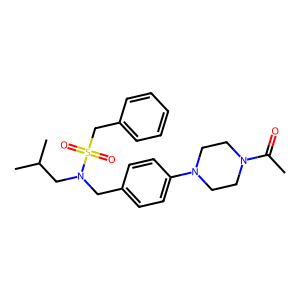

In [3]:
smis = "CC(C)CN(Cc1ccc(cc1)N2CCN(CC2)C(C)=O)[S](=O)(=O)Cc3ccccc3"

mol = Chem.MolFromSmiles(smis)
qed_score = rdkit_qed(mol)
print(f"Original QED: {qed_score}")

# Generate an image from the molecule
img = Draw.MolToImage(mol, size=(300, 300))
display(img)  # hTis will display the SM image in a Jupyter Notebook

## 2.3 Guided Small Molecule Generation with CMA-ES

Unlike random sampling of the latent space (available when self-hosting NVIDIA `MolMIM` NIM — see [doc](https://docs.nvidia.com/nim/bionemo/molmim/latest/endpoints.html#)), we use a black-box optimizer called CMA-ES to guide small molecule generation. In the cells below, CMA-ES is used to optimize the [QED score](https://www.nature.com/articles/nchem.1243) of generated molecules while maintaining similarity to the `SEED` molecule in [PDB: 4WQP](https://www.rcsb.org/structure/4WQP).

For demonstration purposes, we’ll generate molecules using a range of minimum similarity thresholds — from 0.6 to 0.9 — at three evenly spaced intervals.

In [87]:
# Create a dictionary to store the results
results = {}

# Create a list of minimum similarities
num_min_sims = 3
min_sims = np.linspace(0.7, 0.95, num_min_sims)

In [88]:
def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    fingerprint_radius_param = 2
    fingerprint_nbits = 2048

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = GetMorganFingerprintAsBitVect(
        reference_mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits
    )

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)

### Set up the `MolMIM` NIM URL and `API_KEY`

NOTE: Be sure to follow the steps in the [README](https://github.com/bf-nv/bionemo_tutorials/blob/main/README.md) to embed your NVIDIA `API_KEY` into your Google Colab environment.

In [89]:
API_KEY = userdata.get('API_KEY')
# print(API_KEY)

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/json",
}

invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/molmim/generate"

session = requests.Session()

### Query `MolMIM` and aggregate the ligand metrics

The block below contains the main loop. It iterates over each minimum similarity value in the `min_sims` list, generating molecules using the CMA-ES algorithm. For each set, it cleans the generated molecules, calculates their Tanimoto similarity and QED scores, and stores the results in a dictionary called `results`. Each key in this dictionary corresponds to a minimum similarity value, and each value contains the valid SMILES strings, their count, average Tanimoto similarity, and average QED score.

In [90]:
num_molecules = 10

gen_smiles = []
gen_qed = []
gen_tanimoto = []

# Loop through each minimum similarity value
for min_sim in min_sims:
    # Create a dictionary to store the results for this min_sim
    min_sim_results = {'smiles': [], 'num_smiles': [], 'tanimoto_similarity': [], 'qed_score': []}

    # Create the request payload
    payload = {
      "smi": smis,
      "algorithm": "CMA-ES",
      "num_molecules": num_molecules,
      "property_name": "QED",
      "minimize": False,
      "min_similarity": min_sim,
      "particles": 20,
      "iterations": 2,
    }

    # Send the request and get the response
    response = session.post(invoke_url, headers=headers, json=payload)
    response.raise_for_status()
    response_json = response.json()
    print(f"*************** min_sim: {min_sim} ********************")
    print(f"response_json: \n"
          f"{response_json}")

    # Extract the generated SMILES
    gen_smiles_list = [i['sample'] for i in ast.literal_eval(response_json['molecules'])]
    print(f"gen_smiles_list: \n"
          f"{gen_smiles_list}")
    # Get the molecule objects out of valid SMILES
    valid_mol_list = [mol for smiles in gen_smiles_list if (mol := Chem.MolFromSmiles(smiles))]
    # Convert to canonical SMILES & deduplicate
    canonical_smiles = set()
    for mol in valid_mol_list:
        canonical_smi = Chem.MolToSmiles(mol, canonical=True)
        canonical_smiles.add(canonical_smi)
    canonical_smiles_list = list(canonical_smiles)
    gen_smiles.extend(canonical_smiles_list)
    print(f"canonical_smiles_list: \n"
          f"{canonical_smiles_list}")

    # Calculate Tanimoto similarity and QED score for each valid SMILES
    for smiles in canonical_smiles_list:
        tanimoto = tanimoto_similarity(smiles, smis)
        mol = Chem.MolFromSmiles(smiles)
        qed_score = qed(mol)
        min_sim_results['tanimoto_similarity'].append(tanimoto)
        min_sim_results['qed_score'].append(qed_score)
    gen_tanimoto.extend(min_sim_results['tanimoto_similarity'])
    gen_qed.extend(min_sim_results['qed_score'])

    # Update min_sim_results - get the average of Tanimoto and QED scores, store generated SMILES
    min_sim_results_mean = {}
    min_sim_results_mean['tanimoto_similarity'] = np.mean(min_sim_results['tanimoto_similarity'])
    min_sim_results_mean['qed_score'] = np.mean(min_sim_results['qed_score'])
    min_sim_results_mean['num_smiles'] = len(canonical_smiles_list)
    min_sim_results_mean['smiles'] = canonical_smiles_list

    # Store the results for this min_sim
    results[min_sim] = min_sim_results_mean

*************** min_sim: 0.7 ********************
response_json: 
{'molecules': '[{"sample": "CC(C)NC(=O)CN1C(=O)C(C)(C)NC(=O)c2ccccc21", "score": 0.8763662760197254}, {"sample": "CC(C)CN(Cc1ccccc1)Cc1ccc2c(c1)NC(=O)CN2C", "score": 0.8722207198538514}, {"sample": "CCCN1C(=O)CN(CC(C)C)C(=O)c2ccccc21", "score": 0.8462692280382759}, {"sample": "CC(C)CN(CC(=O)N1CCN(C)CCN1)C(=O)C(C)(C)C", "score": 0.834003236746121}, {"sample": "CN(C)CCCN(Cc1ccccc1)Cc1ccc2c(c1)CCC(=O)N2", "score": 0.7902675640034036}, {"sample": "CC(C)CN(CCCN)C(=O)C1(Cc2ccccc2)CCCCC1", "score": 0.7825016519968321}, {"sample": "CC(C)C(=O)Nc1ccc(C(=O)N(CCN(C)C)Cc2ccccc2)cc1", "score": 0.7770534517028448}, {"sample": "CC(=O)c1ccccc1C(=O)N(CCN1CCNC(=O)C1)CC(C)C", "score": 0.7590011856643101}, {"sample": "CC(C)CN(CCCN(C)C)Cc1ccccc1", "score": 0.6973287315059953}, {"sample": "CC(=O)c1cc(CN(Cc2ccccc2)CC(C)C)ccc1N1CCCNC1=O", "score": 0.6735446071373539}]', 'score_type': 'QED'}
gen_smiles_list: 
['CC(C)NC(=O)CN1C(=O)C(C)(C)NC(=O)c2c

[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerator
[22:33:15] DEPRECATION WARNING: please use MorganGenerat

*************** min_sim: 0.825 ********************
response_json: 
{'molecules': '[{"sample": "CN(Cc1cccc2c1CC(=O)N2C)C(=O)c1ccccc1", "score": 0.872315825331093}, {"sample": "CC(C)C(=O)Nc1cccc(C(=O)N(C)CCN2CCCC2=O)c1", "score": 0.8663413734548647}, {"sample": "CN1CCc2c(CN(Cc3ccccc3)CC(C)(C)C(=O)O)cccc2C1=O", "score": 0.7994688822400934}, {"sample": "CCN1CCN(c2cccc(C(=O)N(CC(=O)O)Cc3ccccc3)c2)CC1", "score": 0.7986006808307629}, {"sample": "CC(C)CN(CN1C(=O)c2ccccc2C1=O)C(=O)C1CCC1", "score": 0.7847725398008915}, {"sample": "CC1=C(C(=O)NCCc2ccccc2)C2(CCN(C)CC2)C(=O)N1Cc1ccccc1", "score": 0.784096114079854}, {"sample": "CN(CCN1CCOC1=O)C(=O)c1ccc(CCc2ccccc2)cc1", "score": 0.7696542164349974}, {"sample": "CC(C)CN1CCC(=O)N(CCC(=O)Nc2ccccc2)C(=O)c2ccccc21", "score": 0.7622668457279673}, {"sample": "CC(C)CCN(Cc1ccccc1)CN1CC(=O)N(C)C1=O", "score": 0.72650678594548}, {"sample": "CC(C)CNC(=O)c1ccccc1CN(CC(=O)N1CCN(C)CC1)Cc1ccccc1", "score": 0.6568466268430821}]', 'score_type': 'QED'}
gen_smiles_l

[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerator
[22:33:16] DEPRECATION WARNING: please use MorganGenerat

*************** min_sim: 0.95 ********************
response_json: 
{'molecules': '[{"sample": "CC(C)CN(C(=O)c1ccccc1)c1ccc2c(c1)CNC(=O)N2C", "score": 0.9257356924822028}, {"sample": "CC(C)N(CCc1ccccc1)C1CCC2(CCNC2=O)CC1", "score": 0.9033376479333939}, {"sample": "CC(=O)NCC(=O)N(Cc1ccccc1)CN1CCC2(CCC2)C1", "score": 0.8682200668608412}, {"sample": "CCN1C[C@H](NC(=O)c2ccc(CNC(C)=O)cc2)C2(CC2)C1", "score": 0.8662444977763712}, {"sample": "CC(C)CN(Cc1ccccc1)C(=O)CN1CC(=O)NC(C)(C)C1=O", "score": 0.8473969286588744}, {"sample": "CC(C)Cc1ccc(C(=O)N2CC(=O)NC3(CCN(Cc4ccccc4)CC3)C2)cc1", "score": 0.8071997955117176}, {"sample": "CC(C)CN(CCNC(=O)c1ccccc1)C(=O)CN1CCC(C)C1", "score": 0.7861054617177139}, {"sample": "CC(C)Cn1c(CCc2ccccc2)nnc1N1CCN(C(C)C)CC1", "score": 0.7639652766081555}, {"sample": "CC(C)CCN(C(=O)c1ccccc1)S(=O)(=O)c1ccc2c(c1)NC(=O)CCN2C", "score": 0.7610473540424715}, {"sample": "CC(=O)N1CCN(c2ccc(CN(CCN(C)C)C(=O)Cc3ccccc3)cn2)CC1", "score": 0.6489617807749251}]', 'score_type': 'QED

[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerator
[22:33:17] DEPRECATION WARNING: please use MorganGenerat

After the loop concludes, the results are converted into a Pandas dataframe for further analysis.

In [91]:
keys_to_include = ['num_smiles', 'tanimoto_similarity', 'qed_score']
# Create the DataFrame, selecting only the specified keys from each inner dictionary
df = pd.DataFrame({k: {key: val[key] for key in keys_to_include} for k, val in results.items()}).T.reset_index()
print(df)

   index  num_smiles  tanimoto_similarity  qed_score
0  0.700        10.0             0.264919   0.790856
1  0.825        10.0             0.262303   0.782087
2  0.950        10.0             0.262983   0.817821


### Visualize the ligand metrics

The block below generates three plots to visualize the results:

1) The number of valid SMILES strings,
2) The average Tanimoto similarity, and
3) The average QED score at each minimum similarity threshold.

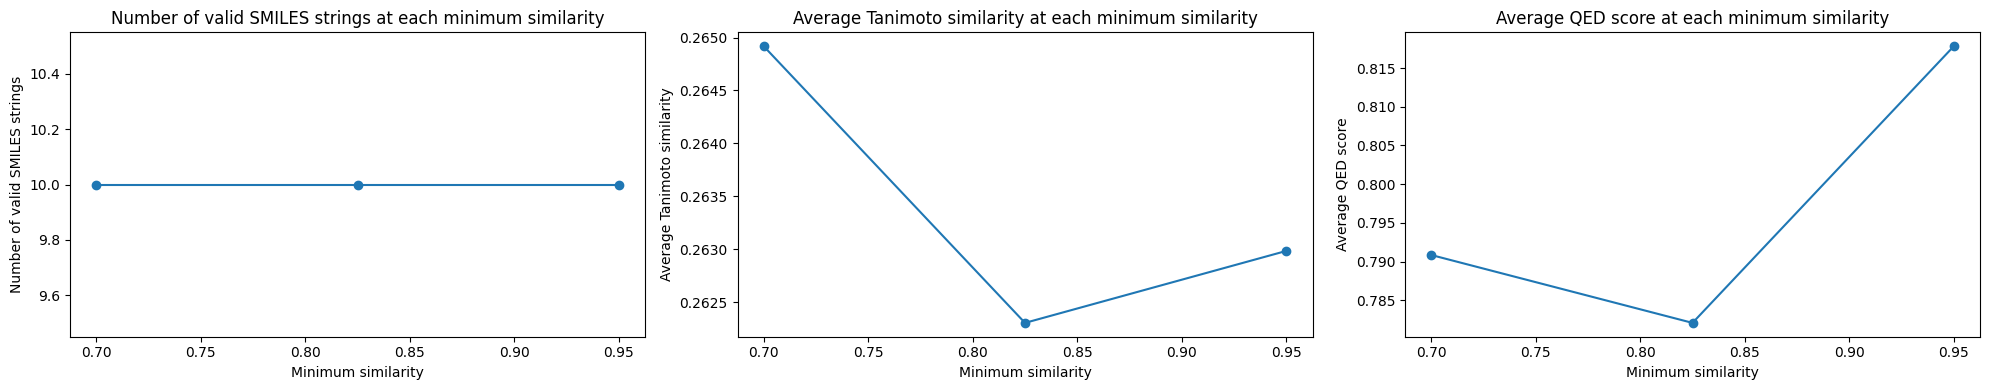

In [92]:
# Create the plots
plt.figure(figsize=(20, 4))

# Plot the number of valid SMILES strings at each min_sim
plt.subplot(1, 3, 1)
plt.plot(df['index'], df['num_smiles'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Number of valid SMILES strings')
plt.title('Number of valid SMILES strings at each minimum similarity')

# Plot the average Tanimoto similarity at each radius
plt.subplot(1, 3, 2)
plt.plot(df['index'], df['tanimoto_similarity'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Average Tanimoto similarity')
plt.title('Average Tanimoto similarity at each minimum similarity')

# Plot the average QED score at each radius
plt.subplot(1, 3, 3)
plt.plot(df['index'], df['qed_score'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Average QED score')
plt.title('Average QED score at each minimum similarity')

plt.tight_layout()
plt.show()

### Visulaize the generated ligands

In [93]:
gen_minsims = [float(item) for item in list(min_sims) for _ in range(num_molecules)]
gen_tanimoto = [round(_, 2) for _ in gen_tanimoto]
gen_qed = [round(_, 2) for _ in gen_qed]

df_viz = pd.DataFrame({
    'smiles': gen_smiles,
    'minsim': gen_minsims,
    'tanimoto': gen_tanimoto,
    'qed': gen_qed
})
df_viz = df_viz.sort_values(
    by=['minsim', 'tanimoto', 'qed'],
    ascending=[False, False, False])
df_viz.head()

,smiles,minsim,tanimoto,qed
23,CC(=O)N1CCN(c2ccc(CN(CCN(C)C)C(=O)Cc3ccccc3)cn...,0.95,0.38,0.65
22,CC(C)CN(Cc1ccccc1)C(=O)CN1CC(=O)NC(C)(C)C1=O,0.95,0.32,0.85
26,CC(=O)NCC(=O)N(Cc1ccccc1)CN1CCC2(CCC2)C1,0.95,0.27,0.87
29,CC(C)Cc1ccc(C(=O)N2CC(=O)NC3(CCN(Cc4ccccc4)CC3...,0.95,0.27,0.81
28,CC(C)CN(CCNC(=O)c1ccccc1)C(=O)CN1CCC(C)C1,0.95,0.26,0.79


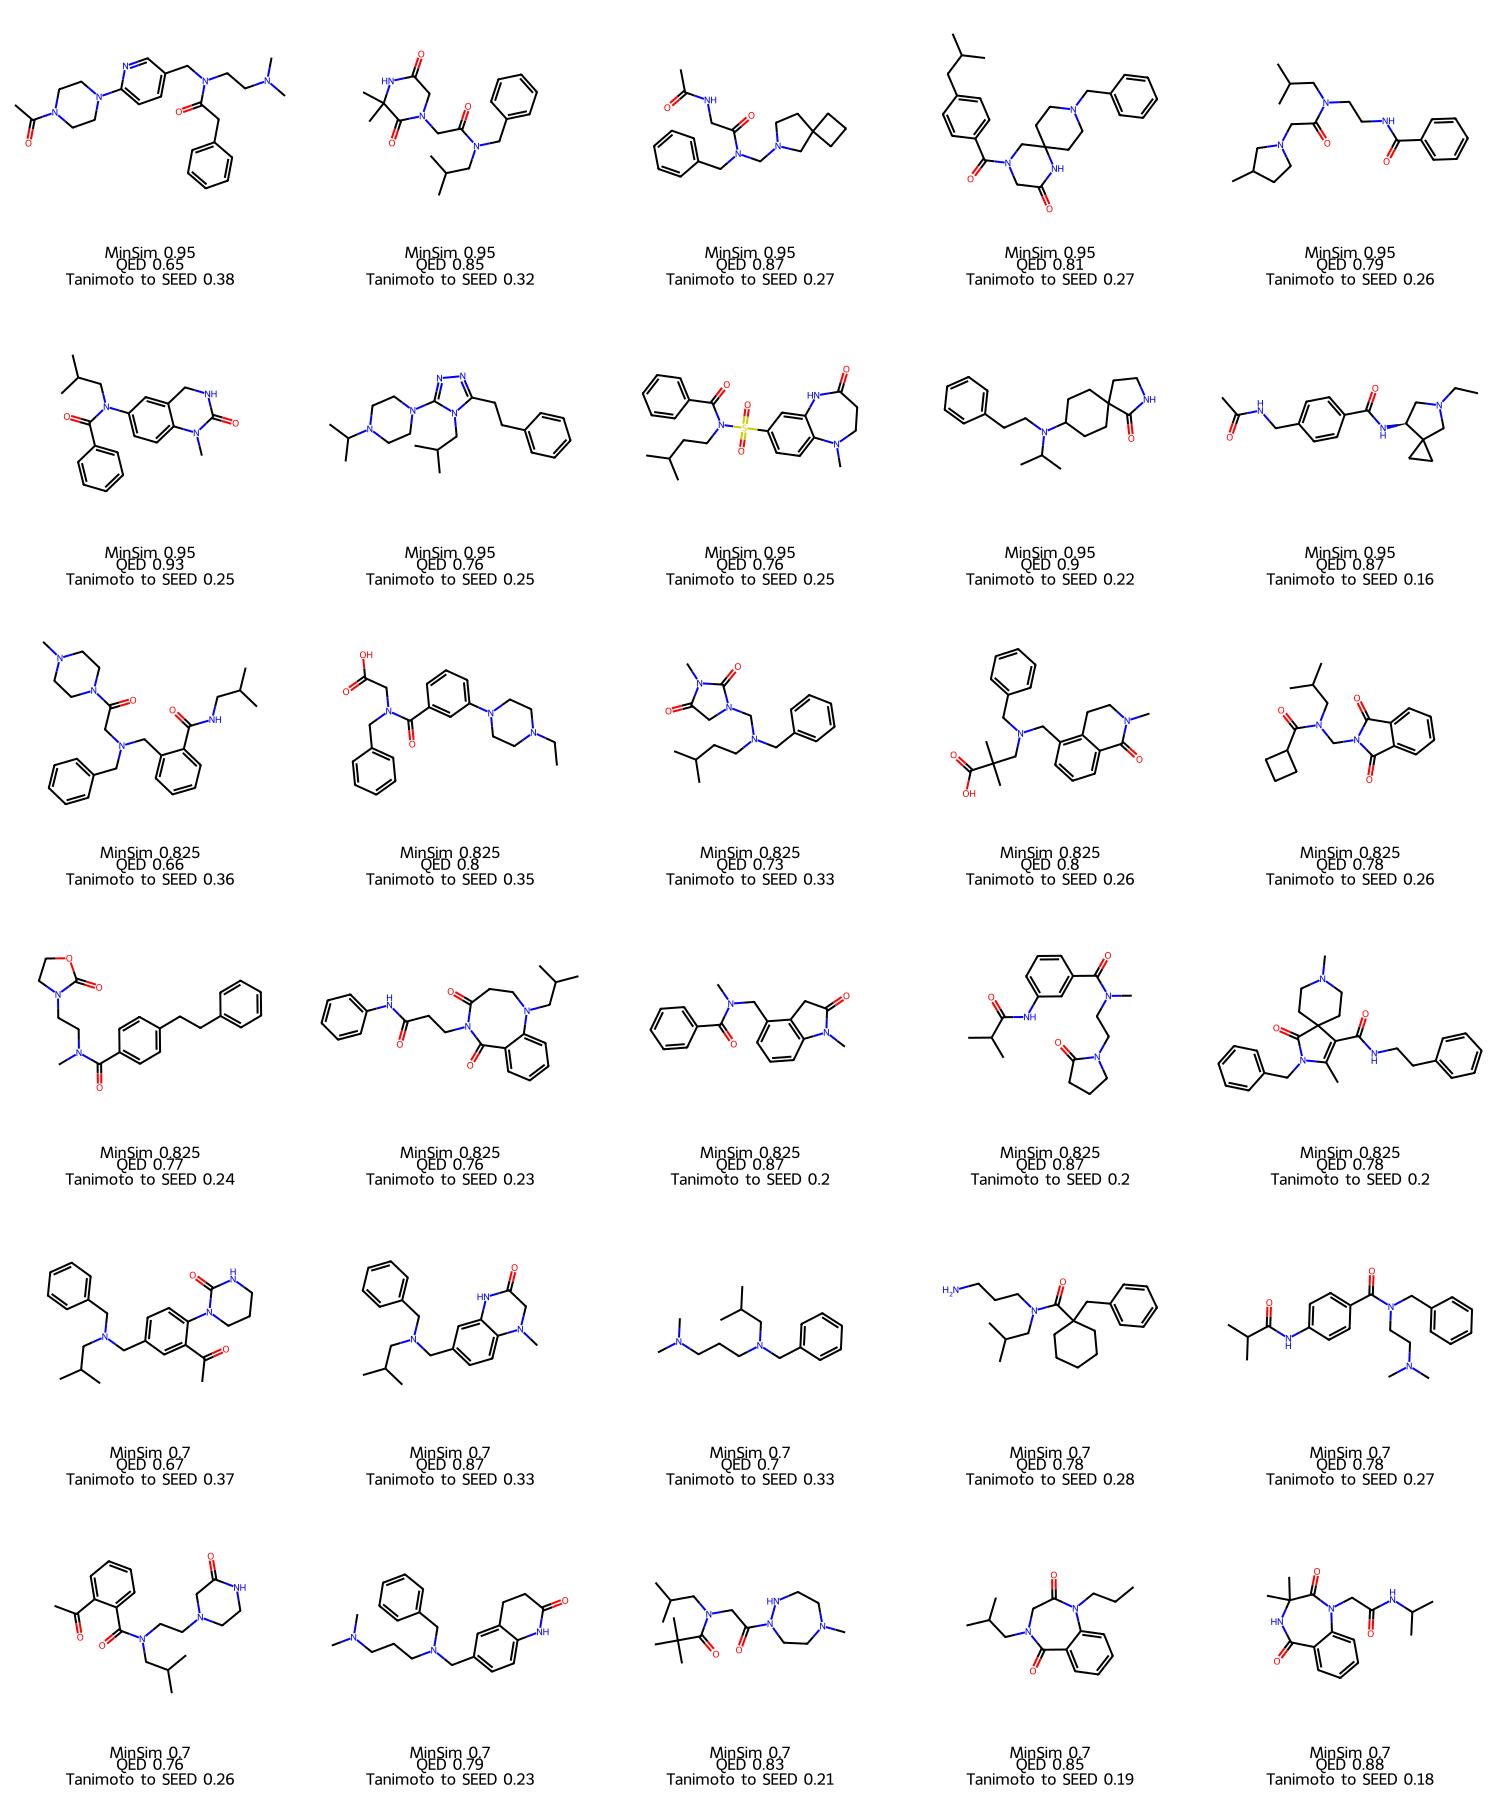

In [99]:
df_smiles = df_viz["smiles"].tolist()
df_minsim = df_viz["minsim"].tolist()
df_tanimoto = df_viz["tanimoto"].tolist()
df_qed = df_viz["qed"].tolist()
ms = [Chem.MolFromSmiles(_) for _ in df_smiles]
dopts = Draw.MolDrawOptions()
dopts.legendFontSize=16
dopts.legendFraction=0.2
Draw.MolsToGridImage(ms,
                     molsPerRow=5,
                     subImgSize=(300, 300),
                     legends = [f"MinSim {min_sim}\nQED {qed}\nTanimoto to SEED {tanimoto}" for min_sim, qed, tanimoto in zip(df_minsim, df_qed, df_tanimoto)],
                     drawOptions=dopts,
                     )

## 2.4 Preprocess the Generated Small Molecules for use in `DiffDock`

In [95]:
# choose the first N molecules from the individual runs to use for docking,
# for demo purpose we will set it to 5 for now.
N_molecules_for_docking = 5

# for each sublists, choose the first N molecules
molecules = [
    molecule
    for min_sim_key, min_sim_val in results.items()
    for molecule in min_sim_val['smiles'][:N_molecules_for_docking]
]
print(molecules)

['CC(C)CN(CCCN)C(=O)C1(Cc2ccccc2)CCCCC1', 'CC(C)CN(CCCN(C)C)Cc1ccccc1', 'CC(=O)c1ccccc1C(=O)N(CCN1CCNC(=O)C1)CC(C)C', 'CC(C)CN(Cc1ccccc1)Cc1ccc2c(c1)NC(=O)CN2C', 'CC(C)CN(CC(=O)N1CCN(C)CCN1)C(=O)C(C)(C)C', 'CN1CCc2c(CN(Cc3ccccc3)CC(C)(C)C(=O)O)cccc2C1=O', 'CN(CCN1CCOC1=O)C(=O)c1ccc(CCc2ccccc2)cc1', 'CCN1CCN(c2cccc(C(=O)N(CC(=O)O)Cc3ccccc3)c2)CC1', 'CC(C)CCN(Cc1ccccc1)CN1CC(=O)N(C)C1=O', 'CC(C)CNC(=O)c1ccccc1CN(CC(=O)N1CCN(C)CC1)Cc1ccccc1', 'CCN1C[C@H](NC(=O)c2ccc(CNC(C)=O)cc2)C2(CC2)C1', 'CC(C)Cn1c(CCc2ccccc2)nnc1N1CCN(C(C)C)CC1', 'CC(C)CN(Cc1ccccc1)C(=O)CN1CC(=O)NC(C)(C)C1=O', 'CC(=O)N1CCN(c2ccc(CN(CCN(C)C)C(=O)Cc3ccccc3)cn2)CC1', 'CC(C)CN(C(=O)c1ccccc1)c1ccc2c(c1)CNC(=O)N2C']


In [ ]:
def prepare_output_directory(output):
    """
    Prepare the output directory
    output: str, the output directory
    return: None
    """
    # overwrite the output directory
    if os.path.exists(output):
        shutil.rmtree(output)
    os.makedirs(output)

Convert SMILES to SDF (generate 1 conformer for each SMILES)

In [ ]:
output_dir = "/content/output/molmim_result"
output_dir_clean = os.path.join(output_dir, "clean_mols")
prepare_output_directory(output_dir_clean)

# convert to SDF
output_sdf_files = []
for i, smiles in enumerate(molecules):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    img = Draw.MolToImage(mol, size=(150, 150))
    display(img)

    # save the clean file
    path = f"{output_dir_clean}/molecule_{i}.sdf"
    w = Chem.SDWriter(path)
    w.write(mol)
    w.close()
    print(f"Converted SMILES to SDF: {smiles}")
    output_sdf_files.append(path)

# here are the paths to the generated molecules in SDF format, which can be used for docking
print(output_sdf_files)

### Download SDF files which need to be uploaded in Step 3 - Using DiffDock to Predict Docking Poses

In [ ]:
# Step 1: Zip the directory
zip_filename = "clean_mols.zip"
!cd {output_dir_clean} && zip -r {zip_filename} .

In [ ]:
# Step 2: Download the zipped file
from google.colab import files
files.download(os.path.join(output_dir_clean, zip_filename))